In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from collections import defaultdict

In [12]:
from faircom.pipeline import *
from faircom.communities import *
from faircom.pah_growth_block_model import HomophilyGrowthGenerator2
from faircom.pah_block_model import HomophilyGenerator

Create pre-intervention graphs

In [14]:
# Create start graphs
n=2500
m=2
probability_block = [1.0]
block_sizes = [np.array([1.0])]
minority_sizes = [np.array([0.2])]
repetitions=10
show_std=True
mode="unsafe"
homophilies = [0.8]
generator = ParametersCombinations(HomophilyGenerator(), {'n':n,
                                                 'm':m,
                                                 'attachement_prob' : probability_block,
                                                 'block_sizes': block_sizes,
                                                 'minority_fractions' : minority_sizes,
                                                 'homophily' : homophilies,
                                                 'save_degree': True})

k=100
measures = JoinMeasures([DegreeByClass(["top_k"], minlength=m*n, k=k, com="full_graph"), DegreeByClass(["top_k"], minlength=m*n, k=k, com="global_centrality"),
                         DegreeByClass(["top_k"], minlength=m*n,
                                       k=k, com="local_centrality"),
                        MinorityFraction(),
                         Modularity(),
                         Assortativity(),
                         Assortativity_per_group()])


In [9]:
result1,graph_list1,degree_list1=GraphPipeline(generator, measures).execute(repetitions=repetitions)

In [10]:
with open('p1.pkl', 'wb') as f:
    pkl.dump(degree_list1, f)
with open('graphs1.pkl', 'wb') as f:
    pkl.dump(graph_list1, f)
result1.to_csv('results1.csv', index=False)


Simulate network growth interventions

In [30]:
n=5000
m=2
probability_block = [1.0]
minority_fraction =  [np.array([0.5])]
initial_graphs = graph_list1
repetitions=1
show_std=True
mode="unsafe"
homophilies = [0.2]
generator2 = ParametersCombinations(HomophilyGrowthGenerator2(), {'graph':initial_graphs, 'n':n,
                                                 'm':m,
                                                 'homophily' : homophilies,
                                                'attachement_prob' : probability_block,
                                                'minority_fraction' : minority_fraction,
                                                'save_degree': True})

In [31]:
result2,graph_list2, degree_list2 =GraphPipeline(generator2, measures).execute(repetitions=repetitions)

In [32]:
with open('p2.pkl', 'wb') as f:
    pkl.dump(degree_list2, f)
with open('graphs2.pkl', 'wb') as f:
    pkl.dump(graph_list2, f)
result2.to_csv('results2.csv', index=False)


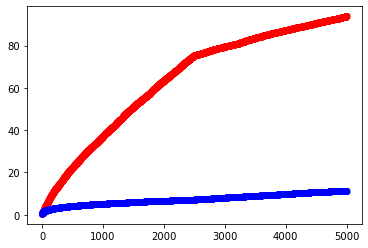

In [10]:
with open('p1.pkl', 'rb') as f:
    degree_list1 = pkl.load(f)
with open('graphs1.pkl', 'rb') as f:
    graph_list1 = pkl.load(f)

with open('p2.pkl', 'rb') as f:
    degree_list2 = pkl.load(f)
with open('graphs2.pkl', 'rb') as f:
    graph_list2 = pkl.load(f)
    
    
const = 10
time_dict_minority = defaultdict(list)
time_dict_majority = defaultdict(list)
    
for it in range(len(graph_list1)):
    degree_dynamic1 = degree_list1[it]
    degree_dynamic2 = degree_list2[it]
    minority2 = graph_list2[it].nodes('minority')
    minority1 = graph_list1[it].nodes('minority')
    for n in degree_dynamic2.keys():
        for t in degree_dynamic2[n].keys():
            degree_dynamic1[n][t+len(minority1)]= degree_dynamic2[n][t]
        
    for n in degree_dynamic1.keys():
        sorted_keys = list(degree_dynamic1[n].keys()) #time
        if len(sorted_keys) < const:
            continue
        offset = const#*sorted_keys[0]
        if offset in sorted_keys  : #first 100 nodes
            for t in sorted_keys:
                if minority2[n]== True:
                    time_dict_minority[t].append(float(degree_dynamic1[n][t])/float(degree_dynamic1[n][offset]))                      
                else:
                    time_dict_majority[t].append(float(degree_dynamic1[n][t])/float(degree_dynamic1[n][offset]) )    
y = []
x = time_dict_minority.keys()
for k in time_dict_minority.keys():
    v_list = time_dict_minority[k]
    y.append(np.mean(v_list))

plt.scatter(x, y, color = 'r', alpha = 0.4)

y = []
x = time_dict_majority.keys()
for k in time_dict_majority.keys():
    v_list = time_dict_majority[k]
    y.append(np.mean(v_list))


plt.scatter(x, y, color = 'b', alpha = 0.4)

with open('degree_min.pkl', 'wb') as f:
    pkl.dump(time_dict_minority, f)
with open('degree_max.pkl', 'wb') as f:
    pkl.dump(time_dict_majority, f)
